In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sksurv.datasets import load_gbsg2, load_whas500, load_aids
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

import shap

## Modeling

In [2]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

random_state = 20
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state
)

rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

## Importance

In [3]:
result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)

In [37]:
df=pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
)#.sort_values(by="importances_mean", ascending=False)

## SHAP

100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


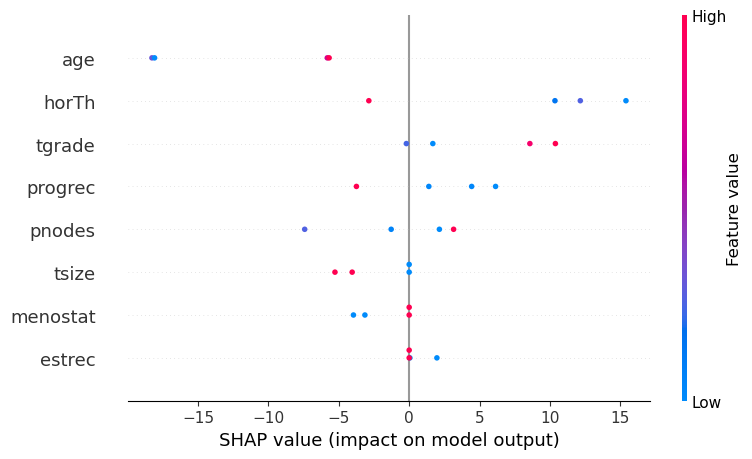

In [13]:
eps = 1.0
X_mean = X_test.mean().to_frame().T

y_mean = rsf.predict(X_mean)
y_pred = rsf.predict(X_test)

sel_mask = np.abs(y_pred - y_mean) < eps

ex = shap.KernelExplainer(rsf.predict, X_mean)
shap_vals = ex.shap_values(X_test[sel_mask])
shap.summary_plot(shap_vals, X_test[sel_mask], feature_names=['pnodes', 'progrec', 'tsize', 'estrec', 'age', 'horTh', 'tgrade', 'menostat'])

### Debug

In [9]:
# same as y_mean
ex.expected_value

47.29479115755801

In [12]:
shap_vals

array([[  2.14683409,   4.43989842,  -5.27348516,   0.        ,
         -5.68817714,  -2.86643328,  10.38956038,  -3.14551689],
       [ -7.42507585,   6.13949245,   0.        ,   0.04962807,
        -18.2771263 ,  10.35851787,   8.57565362,   0.        ],
       [ -1.27924015,   1.3968804 ,   0.        ,   1.96976859,
        -18.09230322,  15.40372544,  -0.19943649,   0.        ],
       [  3.15693426,  -3.74824793,  -4.05090304,   0.        ,
         -5.81945952,  12.16131498,   1.68014617,  -3.95985818]])

In [15]:
shap_vals[0]

array([ 2.14683409,  4.43989842, -5.27348516,  0.        , -5.68817714,
       -2.86643328, 10.38956038, -3.14551689])

In [18]:
shap2 = ex(X_test[sel_mask])

100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


In [19]:
shap2

.values =
array([[  2.14683409,   4.43989842,  -5.27348516,   0.        ,
         -5.68817714,  -2.86643328,  10.38956038,  -3.14551689],
       [ -7.42507585,   6.13949245,   0.        ,   0.04962807,
        -18.2771263 ,  10.35851787,   8.57565362,   0.        ],
       [ -1.27924015,   1.3968804 ,   0.        ,   1.96976859,
        -18.09230322,  15.40372544,  -0.19943649,   0.        ],
       [  3.15693426,  -3.74824793,  -4.05090304,   0.        ,
         -5.81945952,  12.16131498,   1.68014617,  -3.95985818]])

.base_values =
array([47.29479116, 47.29479116, 47.29479116, 47.29479116])

.data =
array([[ 43.,  19.,   1.,   1.,   4., 233.,  40.,   0.],
       [ 47.,  10.,   0.,   0.,   2.,  58.,  38.,   1.],
       [ 44.,  23.,   0.,   0.,   1.,  27.,  29.,   1.],
       [ 60., 363.,   1.,   1.,   3.,  78.,  25.,   0.]])

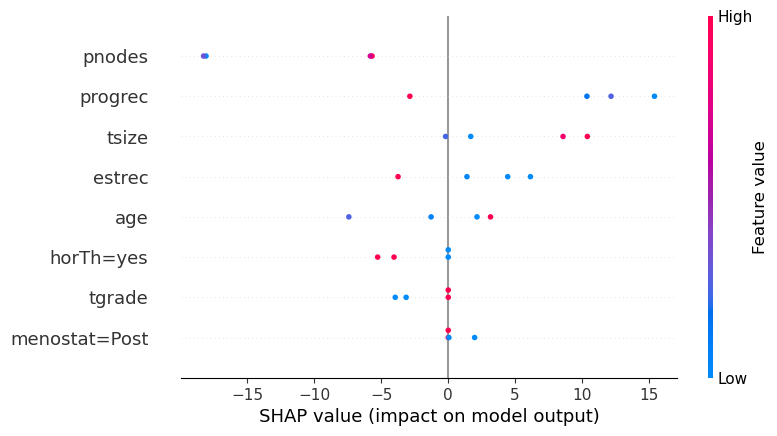

In [31]:
shap.plots.beeswarm(shap2)

In [ ]:
df2=df.reindex(['pnodes', 'progrec', 'tsize', 'estrec', 'age', 'horTh=yes', 'tgrade', 'menostat=Post']).reset_index()

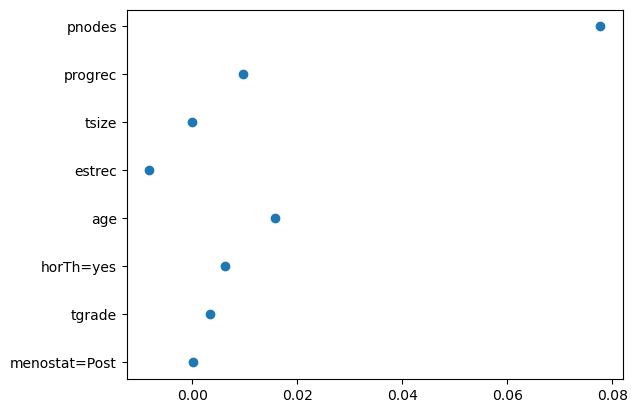

In [49]:
plt.scatter(df2['importances_mean'], df2['index'])

## Join

Text(0.5, 0, 'feature importance')

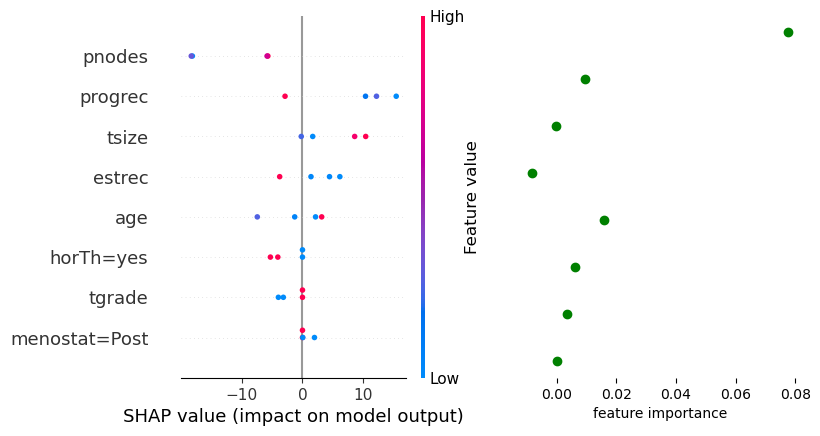

In [66]:
plt.figure()

plt.subplot(1, 2, 1)
shap.plots.beeswarm(shap2, show=False)

plt.subplot(1, 2, 2)
plt.scatter(df2['importances_mean'], df2['index'], c='green')
plt.yticks([])
plt.box(False)
plt.xlabel('feature importance')